# Neural Networks form Scratch

Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate any function given enough data and compute time.

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. 

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. 

The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards).

## Backpropagation

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. 

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$


The weights are updates using this gradient, scaled by a learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Losses in PyTorch

Through the `nn` module, PyTorch provides losses such as the Negative Log-likelihood loss (`nn.NLLLoss()`). Usually the loss is assigned to a variable named `criterion`. 

With a classification problem such as MNIST, the softmax function is used to predict class **probabilities**.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). 

> **Note:** It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [30]:
import torch
from torch import nn
# import torch.nn.functional as F # Used when defining a Class
from torchvision import datasets, transforms
from torch import optim

from time import time
import matplotlib.pyplot as plt

%matplotlib inline

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5]),
                              ])

# Download and load the training data
train_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

It is recommended to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). 

The actual probabilites can be obtained by taking the exponential `torch.exp(output)`:
$$P(x) = \exp^{(output)} $$

With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

# Backpropagation

## Autograd

Use the loss to perform backpropagation in order to calibrate the weights.
> Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. 

`Autograd` works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. 

You can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`, using a content manager `with`

## Training the network!

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

### Summing up:
1. Run data through the network (Feed forward) to obtain an output (prediction/classification) 
2. Calculate the loss based on the output and known value
3. Backpropagate the loss (`loss.backward()`), calculating the gradients for each step. Once we have the gradients, we can make a gradient descent step for each weight. 
4. Using the Optimizer, perform a gradient descent step in the direction that minimizes the error, updating the weights.

> **Note**: while training, the model will repeat the previous steps multiple times. It is critical to zero the gradients (`optimizer.zero_grad()`) on each training pass, otherwise it will retain gradients from previous steps.

### Training the Neural Network

Now we will train the network for all the images.

**Epoch**: one pass through the entire dataset.
**Batch**: while looping through the `train_loader`, specify how many images will be used at a time.

For each batch, we perform a training pass: 
+ calculate the loss
+ do a backwards pass
+ update the weights

In [19]:
input_vector = 28*28 # size of 28 by 28 pixel image, flattened to a single vector
output_classes = 10 #total classes to be predicted

model = nn.Sequential(nn.Linear(input_vector, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, output_classes),
                      nn.LogSoftmax(dim=1)) # Calculate along Columns, so each row sums 1

criterion = nn.NLLLoss() # Negative Log-likelihood loss
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 10
batch_size = len(train_loader)

start = time()
for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Reset the optimizer
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        elapsed = time()
    
    print(f"Training loss: {running_loss/batch_size :.4f} | Time: {elapsed-start :.0f} sec")

Training loss: 1.8750 | Time: 8 sec
Training loss: 0.8423 | Time: 16 sec
Training loss: 0.5165 | Time: 25 sec
Training loss: 0.4265 | Time: 33 sec
Training loss: 0.3848 | Time: 41 sec
Training loss: 0.3598 | Time: 50 sec
Training loss: 0.3423 | Time: 58 sec
Training loss: 0.3285 | Time: 66 sec
Training loss: 0.3171 | Time: 75 sec
Training loss: 0.3075 | Time: 83 sec


With the network trained, we can check out it's predictions.

In [56]:
def view_classify(image, probability):
    # Preparing data to be used
    probability = probability.data.numpy().squeeze() # remove batch information
    image = img.resize(1,28,28) # from flatten to matrix structure
    image = image.numpy().squeeze() # remove batch information
    
    # Plotting actual image and Classification Probabilities
    fig, axes = plt.subplots(figsize=(6,9), ncols=2)

    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title('Actual Image')

    axes[1].barh(range(10), probability)
    axes[1].set_aspect(0.1)
    axes[1].set_yticks(range(10))
    axes[1].set_yticklabels(range(10))
    axes[1].set_xlim(0,1)
    axes[1].set_title('Class Probability')
    plt.tight_layout();

    # Print Classification
    highest_class = probability.argmax() # returns index with highest value
    print(f'Predicted Digit: {highest_class} | Likelihood: {probability[highest_class]:.2%}')

### Classify and Visualize

Predicted Digit: 2 | Likelihood: 99.08%


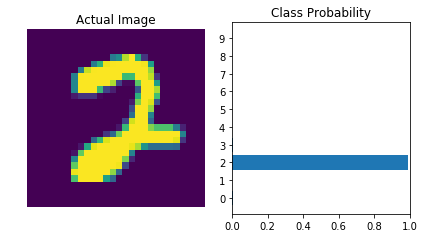

In [64]:

for images, labels in train_loader:

    img = images[0].view(1, 784) # Flatten image into vector
    
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logit = model.forward(img)

    # Output of the network are logits, need to take softmax for probabilities
    probability = torch.exp(logit)
    
view_classify(img, probability)